# UNSW Workshop on Sentiment Analysis

May, 2022 by Christian Hotz-Behofsits

Topics:

 - Online/offline processing
 - Sentiment Analysis (Classification/Positivity)
 - Workflow: (1) always save intermediate results (2) use code versioning (e.g., GitHub) and (3) comment your own code

## Filter Tweets

Online algorithm (= process tweets chunkwise) to filter Tweets. Such an procedure can be scaled to medium-sized data sets spanning billions of rows.

In [3]:
import json
import gzip

with gzip.open('./data/nike_tweets_rnd_filtered.jsonl.gz', 'wt') as of:
    with gzip.open('./data/nike_tweets_rnd.jsonl.gz', 'rt') as f:
    for l in f:
        dct = json.loads(l)
        
        # we will filter out all other languages except en
        if not dct['lang'] == 'en':
            continue

        # avoid scheduled tweets
        if dct['source'] not in ["Twitter Web Client", "Twitter for iPhone", "Twitter for Android"]:
            continue

        # also skip retweets ...
        if dct['text'][:3] == 'RT ':
            continue

        # select only relevant 'columns'
        outp = {
          'created_at': dct['created_at'],
          'text': dct['text']
        }

        # write out to jsonlines file
        of.write(json.dumps(outp) + '\n')

## Volume

First model-free analysis of the data at hand. Vizualizes the daily number of Tweets.

In [111]:
import pandas as pd 

df = pd.read_json(
    # compression is automatically detected
    # but we have to state that the format is 
    # line-wise json
    './data/nike_tweets_rnd_filtered.jsonl.gz', lines = True
    
    # setting the date as column
    # saves us some time later, because it
    # makes it easier to group by this column
).set_index('created_at')

df.head(3)

,text
created_at,
2018-08-03 23:57:12+00:00,Nike boyzzzzzzzzzzzz
2018-08-03 23:54:51+00:00,Guess Drake back on team Nike and I’m all for ...
2018-08-03 23:49:08+00:00,My mom said I have an addiction to adidas and ...


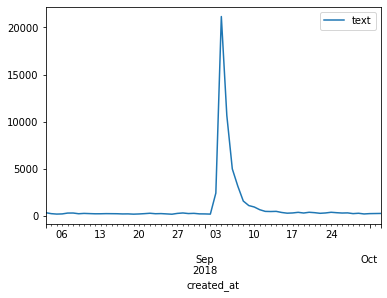

In [119]:
# the created_at column states the time
# when the specific tweet was posted.
# The grouper can be used to aggreagte it
# on daily (D) or weekly (W) level
df.groupby(pd.Grouper(freq='D')).count().plot()

## Sentiment analysis

In [ ]:
# hugging face provides state of the art deep learning models
# the package can be installed as follows
!pip install transformers

In [50]:
from transformers import pipeline

clf = pipeline(
    # we want to carry out a sentiment-analysis task
    'sentiment-analysis', 

    # sentiment model used for inference
    # this is the default
    model = 'distilbert-base-uncased-finetuned-sst-2-english',

    # device=0: use GPU (check your runtime!);
    # device=-1: use CPU (slower, but always available) 
    device=0, 
    
    # defaults to return only the "most-likely" label
    return_all_scores=True
)

In [51]:
clf('I hate it!')

[[{'label': 'NEGATIVE', 'score': 0.9995840191841125},
  {'label': 'POSITIVE', 'score': 0.0004159855598118156}]]

In [64]:
pos_score = lambda txt: clf(txt)[0][1]['score']
pos_score('i love you')

In [67]:
pos_score('i hate you')

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:998: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


0.0008870709571056068

In [82]:
df['pos_score'] = df.text.apply(pos_score)

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:998: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


In [84]:
df.to_json('nike_tweets_rnd_sentiment.jsonl.gz', lines=True, orient='records')

# Analysing the data

In [122]:
import pandas as pd

df = pd.read_json(
    './data/nike_tweets_rnd_sentiment.jsonl.gz', lines=True
).set_index('created_at')

df.head(5)

,text,pos_score
created_at,,
2018-08-03 23:57:12,Nike boyzzzzzzzzzzzz,0.006898
2018-08-03 23:54:51,Guess Drake back on team Nike and I’m all for ...,0.005539
2018-08-03 23:49:08,My mom said I have an addiction to adidas and ...,0.008323
2018-08-03 23:40:49,Nike Boyz,0.947375
2018-08-03 23:38:19,When Sol dresses kysen he's either wearing paj...,0.004370


In [1]:
df.groupby(pd.Grouper(freq='D')).pos_score.median().plot()

NameError: name 'df' is not defined